In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import Union
from pandas._typing import TimedeltaConvertibleTypes
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma
from cvx.covariance.combination import from_sigmas
from experiments.utils.experiment_utils import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [2]:
returns = pd.read_csv('../data/ff5_no_rf.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# Visualize data

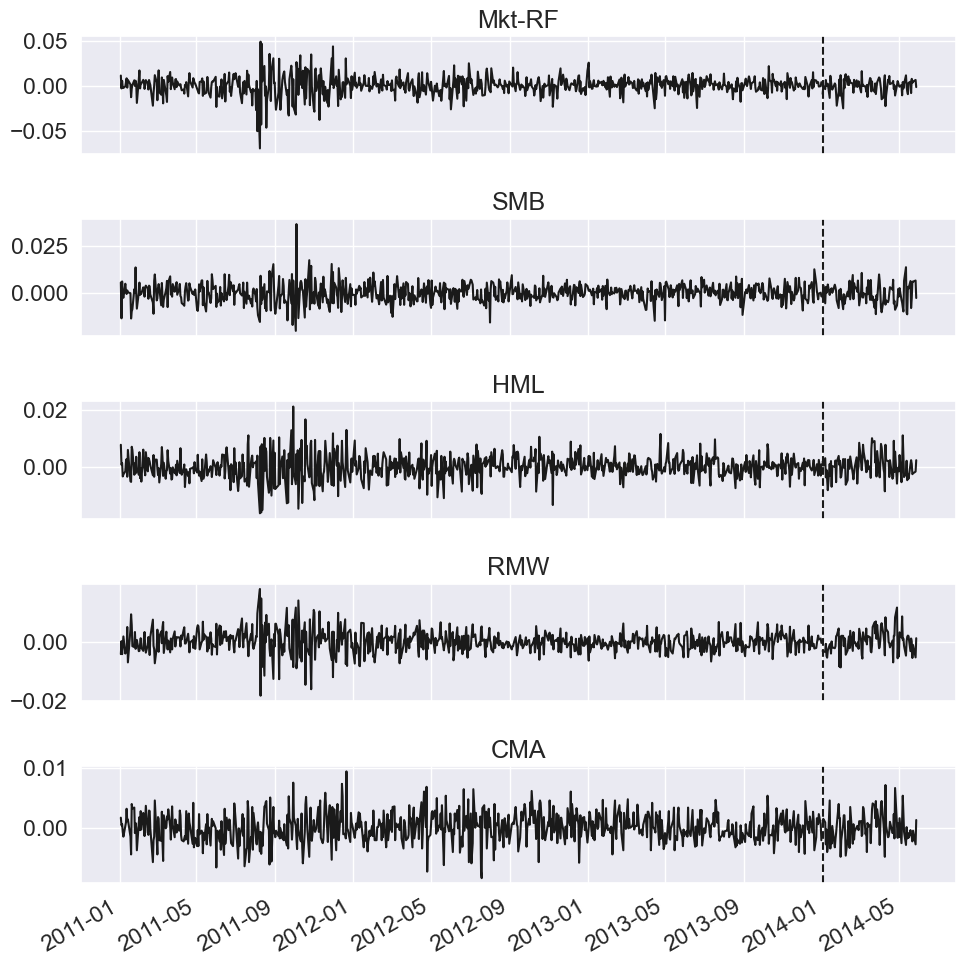

In [3]:
real_start = '2011-01-01'
real_end = '2013-12-31'
sim_start = '2014-01-02'
sim_start_index = returns.index.get_loc(sim_start)
sim_end_index = sim_start_index+100
sim_end = returns.index[sim_end_index]

# Half or returns are train and half test
returns_train = returns.loc[real_start:real_end]
returns_test = returns.loc[sim_start:sim_end]

colors = ['b', 'g', 'r', 'c', 'm']
fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)

for i in range(5):
    ax[i].plot(returns_train.iloc[:,i], color='k')
    ax[i].plot(returns_test.iloc[:,i], color='k')
    # Vertical line in middle
    ax[i].axvline(returns_test.index[0], color='k', linestyle='--');

    ax[i].set_title(returns.columns[i])

fig.autofmt_xdate()
fig.tight_layout();


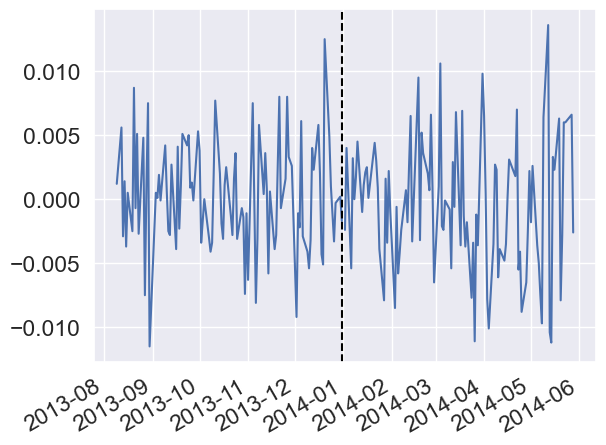

In [22]:
factor = "SMB"

# True returns
plt.figure()
plt.plot(returns_train[factor].iloc[-100:], c="b")
plt.plot(returns_test[factor].loc[sim_start:sim_end], c="b")
plt.gcf().autofmt_xdate()
plt.axvline(returns_train.index[-1], color="black", linestyle="--")
plt.gcf().tight_layout()

#  Generative mode

In [4]:
def _ewma_cov(data, halflife, min_periods=0, n_samples=0, genarative_data=None):
    """
    param data: Txn pandas DataFrame of returns
    param halflife: float, halflife of the EWMA
    """
    for t, ewma, n in _general(
        data.values,
        times=data.index,
        halflife=halflife,
        fct=lambda x: np.outer(x, x),
        min_periods=min_periods,
    ):
        if not np.isnan(ewma).all():
            yield t, pd.DataFrame(index=data.columns, columns=data.columns, data=ewma)

    # Sample from last covariance estimate and recompute n_sample times
    alpha = 1 - np.exp(-np.log(2) / halflife)
    beta = 1 - alpha
    fct=lambda x: np.outer(x, x)

    ewma_temp = ewma
    for i in range(n_samples):
        # Sample from N(0, ewma_temp)
        sample = np.random.multivariate_normal(np.zeros(ewma_temp.shape[0]), ewma_temp)

        if genarative_data is None:
            next_sample = sample
        else:
            next_sample = genarative_data.iloc[i]

        ewma_temp = ewma_temp + (1 - beta) * (fct(next_sample) - ewma_temp) / (
                1 - np.power(beta, n + 1 + 1)
            )
        n += 1
        yield i, pd.Series(index=data.columns, data=sample)


def _general(
    y,
    times,
    # com: Union[float, None] = None,
    # span: Union[float, None] = None,
    halflife: Union[float, TimedeltaConvertibleTypes, None] = None,
    alpha: Union[float, None] = None,
    fct=lambda x: x,
    min_periods=0,
    clip_at=None,
):
    """
    y: frame with measurements for times t=t_1,t_2,...,T
    halflife: EWMA half life

    returns: list of EWMAs for times t=t_1,t_2,...,T
    serving as predictions for the following timestamp

    The function returns a generator over
    t_i, EWMA of fct(y_i)
    """

    def f(k):
        if k < min_periods - 1:
            return times[k], _ewma * np.nan

        return times[k], _ewma, k

    # if com:
    #    alpha = 1 / (1 + com)

    # if span:
    #    alpha = 2 / (span + 1)

    if halflife:
        alpha = 1 - np.exp(-np.log(2) / halflife)

    beta = 1 - alpha

    # first row, important to initialize the _ewma variable
    _ewma = fct(y[0])
    yield f(k=0)

    # iterate through all the remaining rows of y. Start in the 2nd row
    for n, row in enumerate(y[1:], start=1):
        # update the moving average
        if clip_at and n >= min_periods + 1:
            _ewma = _ewma + (1 - beta) * (
                np.clip(fct(row), -clip_at * _ewma, clip_at * _ewma) - _ewma
            ) / (1 - np.power(beta, n + 1))
        else:
            _ewma = _ewma + (1 - beta) * (fct(row) - _ewma) / (
                1 - np.power(beta, n + 1)
            )

        yield f(k=n)


# Full generative mode

In [5]:
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]

def fit_cm_iewma(returns):
    iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
    Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

    # Regularize the first covariance matrix
    fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
    Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

    results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

    cm_iewma = {result.time: result.covariance for result in results}
    weights = {result.time: result.weights for result in results}

    return [*cm_iewma.values()][-1]


In [6]:
def run_sampling_experiment():
    returns_sampled = []
    returns_extended = returns_train.copy()

    from tqdm import trange
    for i in trange(100):
        cov = fit_cm_iewma(returns_extended)
        # Sample from N(0, cov)
        sample = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov)
        returns_sampled.append(sample)

        # Add sample to returns
        returns_extended = pd.concat([returns_extended, pd.DataFrame(sample.reshape(1,-1), columns=returns_train.columns, index=[returns_test.index[i]])])

    return returns_extended

In [7]:
np.random.seed(0)
returns_extended = run_sampling_experiment()

  4%|▍         | 4/100 [00:20<08:13,  5.14s/it]

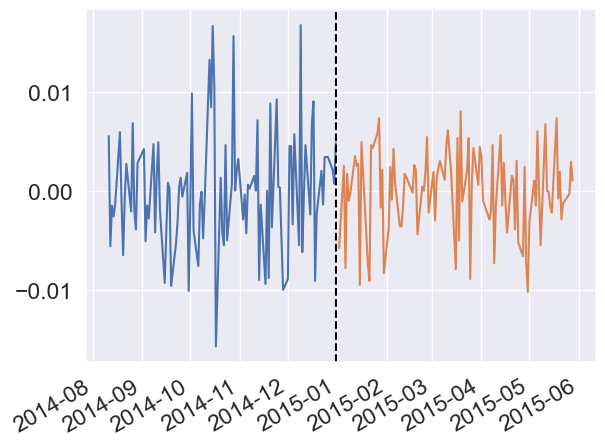

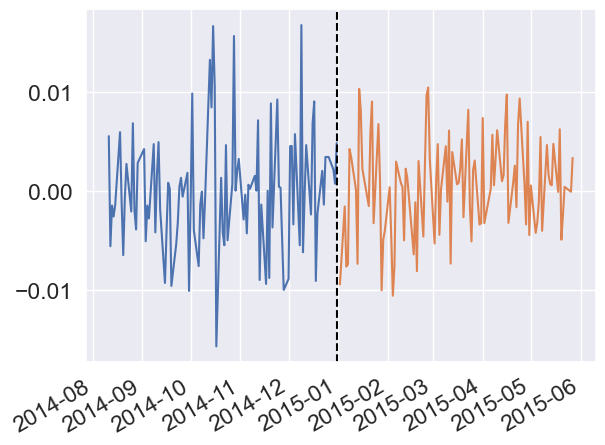

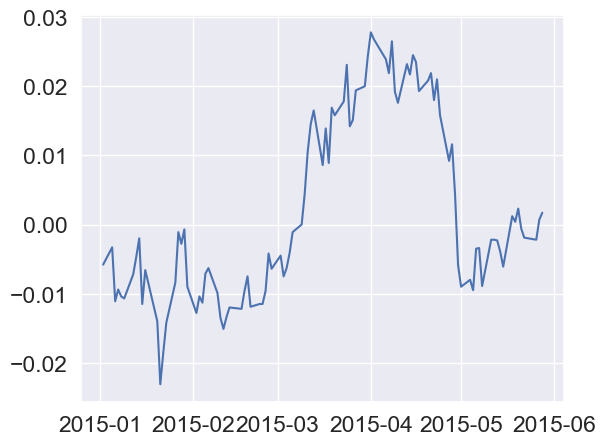

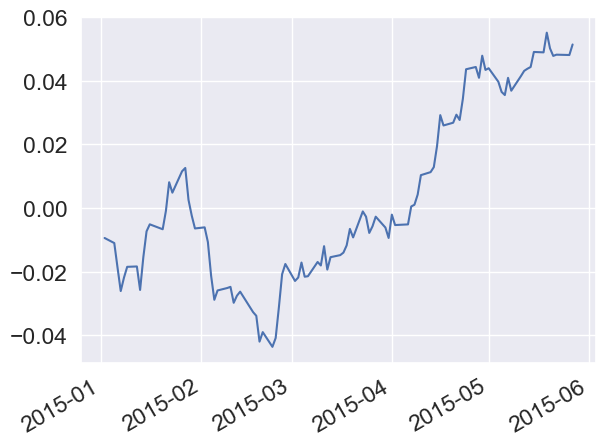

In [33]:
factor = "SMB"

# True returns
plt.figure()
plt.plot(returns_train[factor].iloc[-100:], c='b')
plt.plot(returns_test[factor].loc[sim_start:sim_end], c='b')
plt.gcf().autofmt_xdate()
plt.axvline(returns_train.index[-1], color="black", linestyle="--")
plt.gcf().tight_layout()


# Simulated returns
plt.figure()
plt.plot(returns_train[factor].iloc[-100:])
plt.plot(returns_extended[factor].loc[sim_start:sim_end])
plt.gcf().autofmt_xdate()
plt.axvline(returns_train.index[-1], color="black", linestyle="--")
plt.gcf().tight_layout()



plt.figure()
plt.plot(returns_test[factor].loc[sim_start:sim_end].cumsum())
plt.gcf().tight_layout()


plt.figure()
plt.plot(returns_extended[factor].loc[sim_start:sim_end].cumsum());
plt.gcf().autofmt_xdate()
plt.gcf().tight_layout()

In [21]:
np.random.seed(999)
returns_extended2 = run_sampling_experiment()

100%|██████████| 100/100 [08:38<00:00,  5.19s/it]


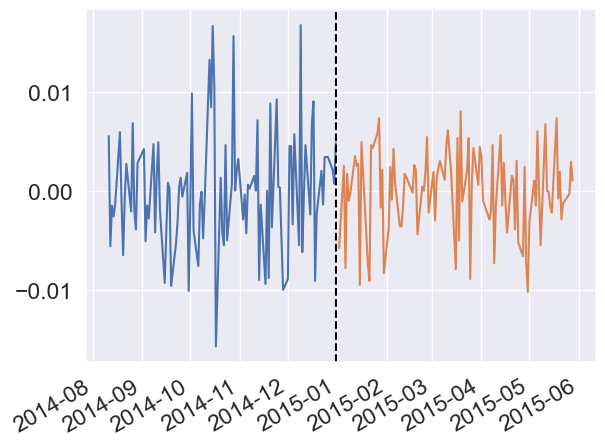

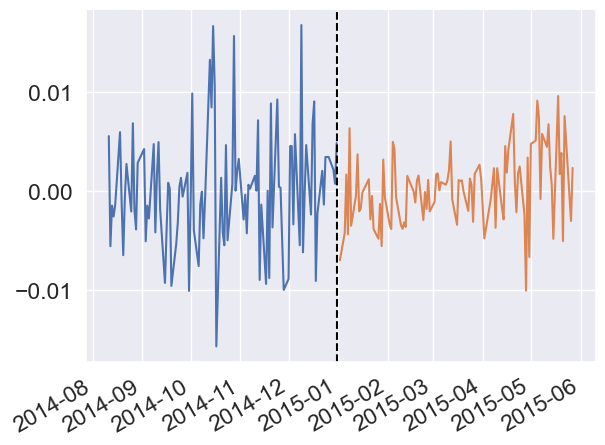

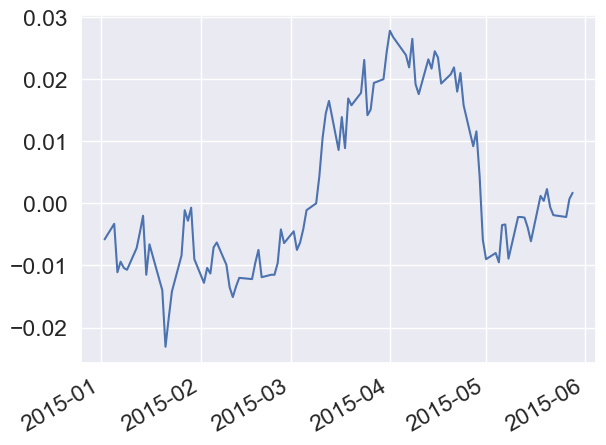

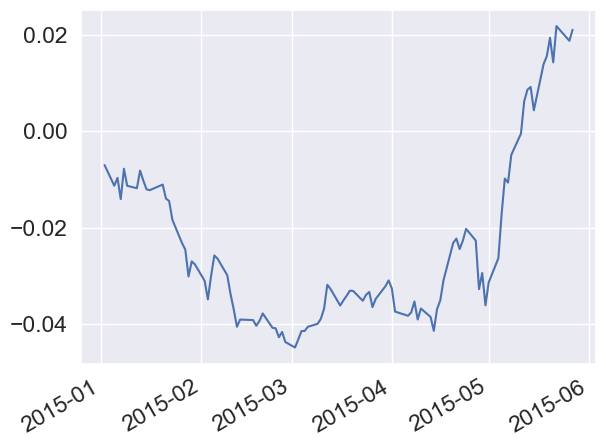

In [34]:
factor = "SMB"

# True returns
plt.figure()
plt.plot(returns_train[factor].iloc[-100:])
plt.plot(returns_test[factor].loc[sim_start:sim_end])
plt.gcf().autofmt_xdate()
plt.axvline(returns_train.index[-1], color="black", linestyle="--")
plt.gcf().tight_layout()

# Simulated returns
plt.figure()
plt.plot(returns_train[factor].iloc[-100:])
plt.plot(returns_extended2[factor].loc[sim_start:sim_end])
plt.gcf().autofmt_xdate()
plt.axvline(returns_train.index[-1], color="black", linestyle="--")
plt.gcf().tight_layout()


plt.figure()
plt.plot(returns_test[factor].loc[sim_start:sim_end].cumsum())
plt.gcf().autofmt_xdate()
plt.gcf().tight_layout()

plt.figure()
plt.plot(returns_extended2[factor].loc[sim_start:sim_end].cumsum());
plt.gcf().autofmt_xdate()
plt.gcf().tight_layout()

# Other generative modes

In [7]:
# EWMA with sampled returns half way through
np.random.seed(1)
ewma = dict(_ewma_cov(returns_train, halflife=63, n_samples=returns_test.shape[0]))

In [8]:
returns_sampled=[]
for i in range(returns_test.shape[0]):
    returns_sampled.append(ewma[i].values)

returns_sampled = pd.DataFrame(returns_sampled, index=returns_test.index, columns=returns_test.columns)

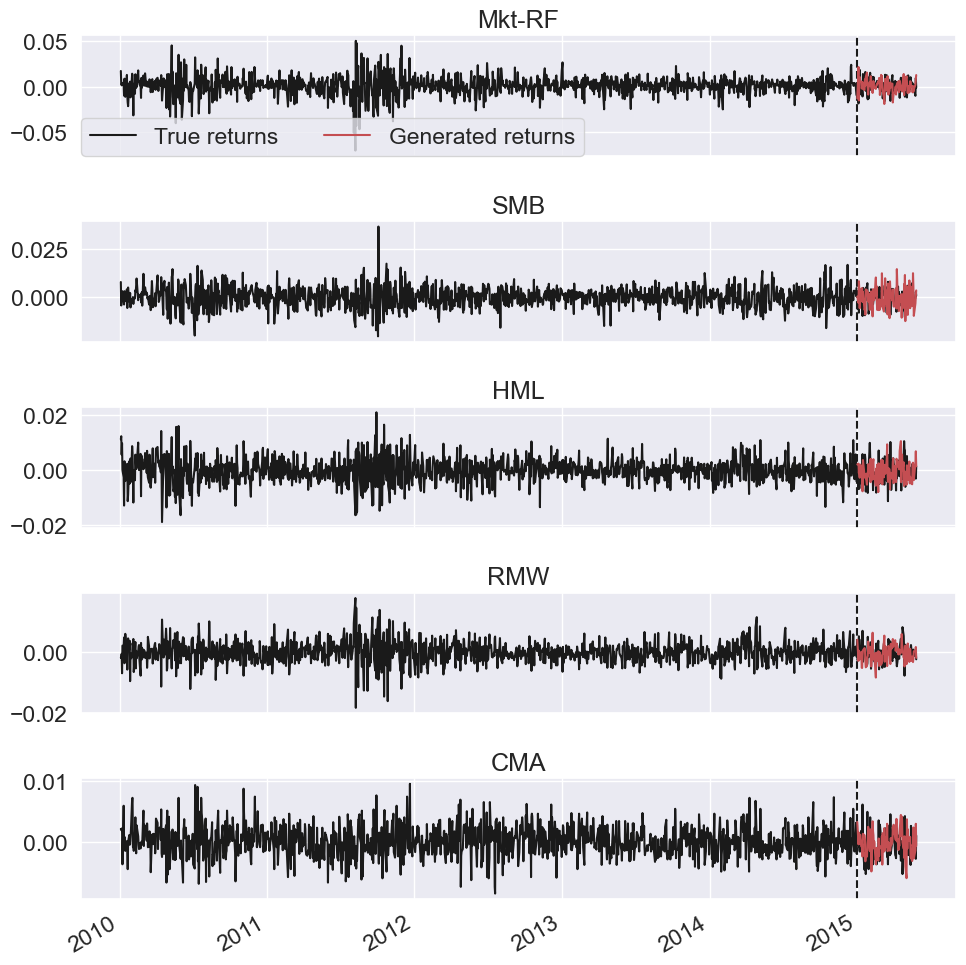

In [9]:
fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)

for i in range(5):
    # Plot true returns
    ax[i].plot(returns_train.iloc[:,i], color='k')
    ax[i].plot(returns_test.iloc[:,i], color='k', label="True returns")
    # Vertical line in middle
    ax[i].axvline(returns_test.index[0], color='k', linestyle='--');

    # Plot sampled returns
    ax[i].plot(returns_sampled.iloc[:,i], color='r', label="Generated returns")
    if i==0:
        # Move legend down
        ax[i].legend(loc='lower left', ncol=2, borderaxespad=0.)

    ax[i].set_title(returns.columns[i])

fig.autofmt_xdate()
fig.tight_layout();

# Updated generative mode

In [9]:
# EWMA with sampled returns half way through
np.random.seed(1)
ewma = dict(_ewma_cov(returns_train, halflife=63, n_samples=returns_test.shape[0], genarative_data=returns_test))

In [10]:
returns_sampled=[]
for i in range(returns_test.shape[0]):
    returns_sampled.append(ewma[i].values)

returns_sampled = pd.DataFrame(returns_sampled, index=returns_test.index, columns=returns_test.columns)

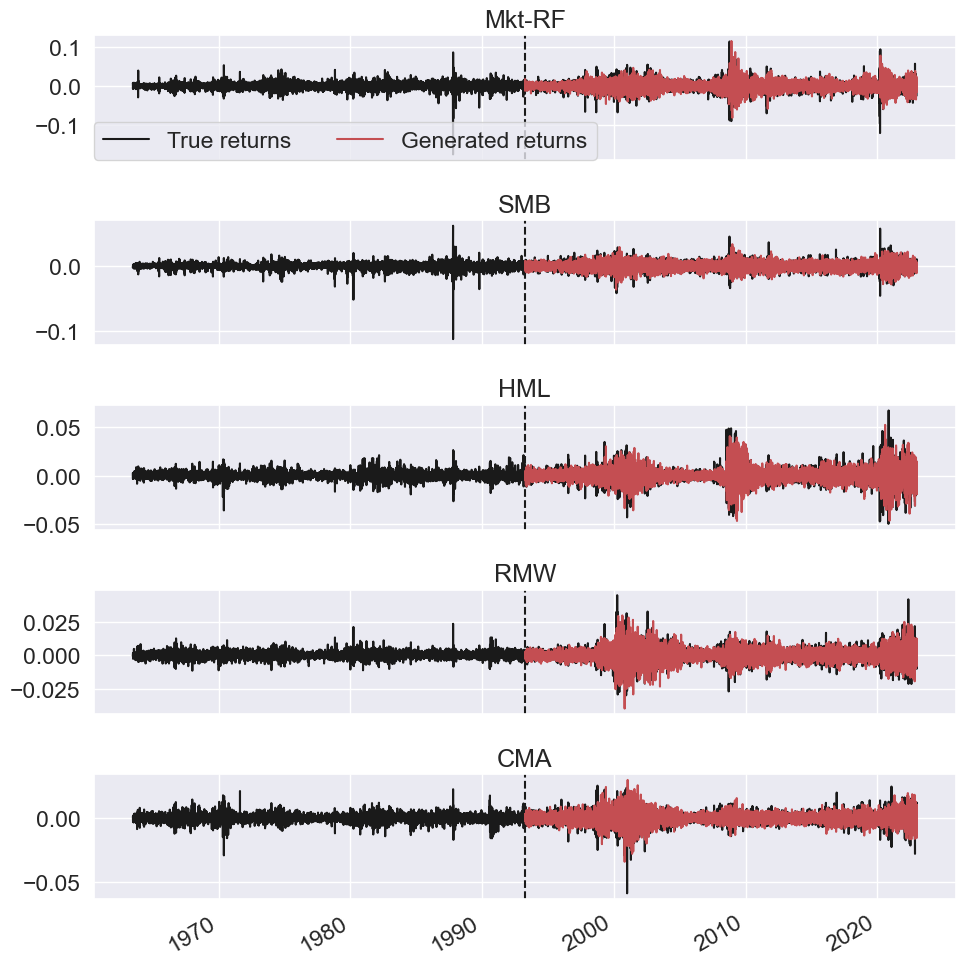

In [11]:
fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)

for i in range(5):
    # Plot true returns
    ax[i].plot(returns_train.iloc[:,i], color='k')
    ax[i].plot(returns_test.iloc[:,i], color='k', label="True returns")
    # Vertical line in middle
    ax[i].axvline(returns_test.index[0], color='k', linestyle='--');

    # Plot sampled returns
    ax[i].plot(returns_sampled.iloc[:,i], color='r', label="Generated returns")
    if i==0:
        # Move legend down
        ax[i].legend(loc='lower left', ncol=2, borderaxespad=0.)

    ax[i].set_title(returns.columns[i])

fig.autofmt_xdate()
fig.tight_layout();